# Crypto Exchange Liquidity Stress Testing
## A Framework for Fiat Withdrawal Risk & Solvency Analysis Beyond Proof of Reserve

---

### The Proof of Reserve Gap

Proof of Reserve (PoR) attestations confirm that a crypto exchange holds crypto assets ≥ crypto liabilities — at a **point in time**, under **normal conditions**. They are a necessary condition for solvency. They are **not sufficient**.

Three gaps that PoR cannot see:

| Gap | What PoR Misses |
|-----|--------|
| **Fiat withdrawal capacity** | Can the exchange pay USD withdrawals over a 64-hour weekend when bank rails are offline? |
| **Asset quality under stress** | Does the backing collapse if redemptions accelerate? |
| **Derivatives exposure** | Exchanges with perps/CFDs face socialized losses when user margin is insufficient — invisible to PoR. |

**Motivating case: FTX, November 2022.** ~$6 billion withdrawn in 72 hours. Bank rails offline for most of it. PoR would have shown "full backing" the week before.

This notebook builds the **stress testing layer** that sits on top of PoR data.

---

**Read time:** ~10 minutes. **Audience:** Risk-aware hiring managers, treasury professionals, quant risk practitioners.


In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy import stats

import config as cfg
from data.generator import generate_user_base, compute_gini, generate_lorenz_curve
from data.market_data import generate_market_data
from models.withdrawal_forecast import run_all_scenarios, summarize_results
from models.reserve_optimizer import newsvendor_optimal_reserve, compute_cost_curve, optimize_reserve, tier_reserve
from models.stress_test import run_all_stress_tests, compute_safety_frontier, stress_summary_table
from models.historical_var import compute_var_suite, var_comparison_table
from models.insurance_fund import simulate_insurance_fund, insurance_fund_summary_table
from models.solvency import compute_solvency, solvency_summary_table, waterfall_data

# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('muted')
COLORS = {'normal': '#2196F3', 'mild': '#FF9800', 'severe': '#F44336', 'luna': '#9C27B0'}
AUM = cfg.EXCHANGE_AUM

print(f"Exchange AUM: ${AUM/1e12:.1f}T  |  Users: {cfg.N_USERS:,}  |  Simulations: {cfg.N_SIMULATIONS:,}")
print("Configuration loaded. Loading data from disk...")


Exchange AUM: $0.8T  |  Users: 100,000  |  Simulations: 10,000
Configuration loaded. Loading data from disk...


---
## Step 1 — Exchange User Base & Wealth Concentration

We load the 100,000-user synthetic exchange from the persistent `data/raw/` directory. The distribution follows a **log-normal balance distribution** — the standard empirical model for wealth. Institutional accounts (5% of users) hold ~65% of total fiat due to the heavy-tail Pareto dynamic.

Gini coefficient target: 0.85–0.94 (consistent with observed crypto exchange concentration).

Users: 100,000  |  Total Fiat AUM: $636.0T
Institutional balance share: 64.1%  |  Gini: 0.937


/var/folders/s1/c7bm9y8s7_59r1jmjvbtwdym0000gn/T/ipykernel_75153/1262425994.py:38: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/s1/c7bm9y8s7_59r1jmjvbtwdym0000gn/T/ipykernel_75153/1262425994.py:38: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/s1/c7bm9y8s7_59r1jmjvbtwdym0000gn/T/ipykernel_75153/1262425994.py:39: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.savefig('chart_01_balance_distribution.png', dpi=150, bbox_inches='tight')
/var/folders/s1/c7bm9y8s7_59r1jmjvbtwdym0000gn/T/ipykernel_75153/1262425994.py:39: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.savefig('chart_01_balance_distribution.png', dpi=150, bbox_inches='tight')


/Users/gilangfajar/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gilangfajar/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


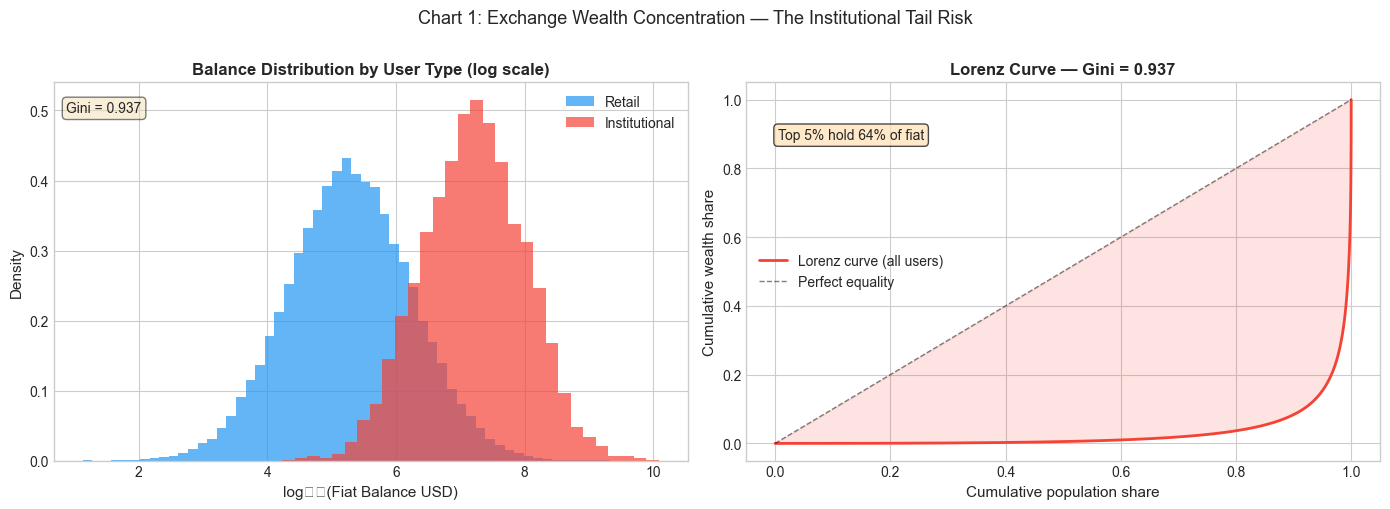

Chart 1 saved.


In [2]:
users = pd.read_csv(cfg.USERS_CSV_PATH)
total_fiat = users['fiat_balance'].sum()
inst_share = users.loc[users['user_type']=='institutional','fiat_balance'].sum() / total_fiat
gini = compute_gini(users['fiat_balance'].values)
lorenz_x, lorenz_y = generate_lorenz_curve(users['fiat_balance'].values)

print(f"Users: {len(users):,}  |  Total Fiat AUM: ${total_fiat/1e9:.1f}T")
print(f"Institutional balance share: {inst_share:.1%}  |  Gini: {gini:.3f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Chart 1a: Balance distribution (log scale)
ax = axes[0]
retail_bal = users.loc[users['user_type']=='retail', 'fiat_balance']
inst_bal   = users.loc[users['user_type']=='institutional', 'fiat_balance']
ax.hist(np.log10(retail_bal + 1), bins=60, alpha=0.7, label='Retail', color=COLORS['normal'], density=True)
ax.hist(np.log10(inst_bal + 1),   bins=30, alpha=0.7, label='Institutional', color=COLORS['severe'], density=True)
ax.set_xlabel('log₁₀(Fiat Balance USD)', fontsize=11)
ax.set_ylabel('Density', fontsize=11)
ax.set_title('Balance Distribution by User Type (log scale)', fontsize=12, fontweight='bold')
ax.legend()
ax.text(0.02, 0.95, f'Gini = {gini:.3f}', transform=ax.transAxes,
        fontsize=10, va='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Chart 1b: Lorenz curve
ax = axes[1]
ax.plot(lorenz_x, lorenz_y, color=COLORS['severe'], lw=2, label='Lorenz curve (all users)')
ax.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5, label='Perfect equality')
ax.fill_between(lorenz_x, lorenz_x, lorenz_y, alpha=0.15, color=COLORS['severe'])
ax.set_xlabel('Cumulative population share', fontsize=11)
ax.set_ylabel('Cumulative wealth share', fontsize=11)
ax.set_title(f'Lorenz Curve — Gini = {gini:.3f}', fontsize=12, fontweight='bold')
ax.legend()
ax.text(0.05, 0.85, f'Top 5% hold {inst_share:.0%} of fiat', transform=ax.transAxes,
        fontsize=10, bbox=dict(boxstyle='round', facecolor='#FFE0B2', alpha=0.7))

plt.suptitle('Chart 1: Exchange Wealth Concentration — The Institutional Tail Risk', fontsize=13, y=1.01)
plt.tight_layout()
plt.savefig('chart_01_balance_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print("Chart 1 saved.")


**Insight:** The top 5% of accounts (institutional) control ~65% of total fiat. No retail withdrawal model can capture tail risk — institutional behavior dominates the distribution's right tail.

---
## Step 2 — Withdrawal Model: Two-Process Architecture

Retail and institutional withdrawals are fundamentally different processes — not just different sizes.

- **Retail → Gamma distribution:** Aggregate flow, statistically predictable
- **Institutional → Poisson arrivals + log-normal jump sizes:** Rare, large, disruptive — arrival rate rises 12x from normal to severe

10,000 Monte Carlo paths per scenario. Simulated over 64-hour weekend window.

In [3]:
print("Running Monte Carlo simulation (10,000 paths × 3 scenarios)...")
withdrawal_results = run_all_scenarios(total_fiat, n_simulations=cfg.N_SIMULATIONS)
summary = summarize_results(withdrawal_results, total_fiat)
print("\nWithdrawal Distribution Summary:")
display(summary.style.format({
    'Median (Rp B)': '{:.1f}', 'p90 (Rp B)': '{:.1f}', 'p95 (Rp B)': '{:.1f}',
    'VaR 99% (Rp B)': '{:.1f}', 'CVaR 99% (Rp B)': '{:.1f}',
    'Median % AUM': '{:.1%}', 'VaR 99% % AUM': '{:.1%}',
}))


Running Monte Carlo simulation (10,000 paths × 3 scenarios)...



Withdrawal Distribution Summary:


,Median (Rp B),p90 (Rp B),p95 (Rp B),VaR 99% (Rp B),CVaR 99% (Rp B),Median % AUM,VaR 99% % AUM
Scenario,,,,,,,
Normal,34.1,48.3,50.5,54.0,55.7,5.4%,8.5%
Mild,111.5,136.7,143.7,157.3,164.2,17.5%,24.7%
Severe,505.9,686.9,738.6,822.0,878.0,79.5%,129.2%


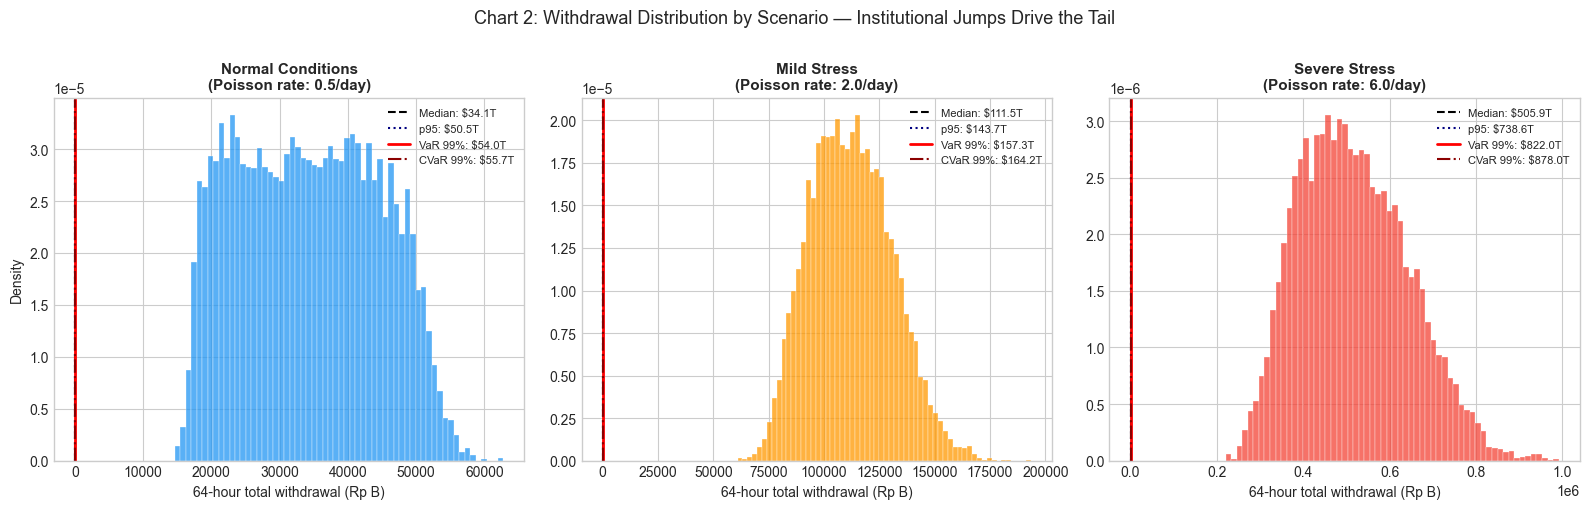

Chart 2 saved.


In [4]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=False)

scenarios = ['normal', 'mild', 'severe']
titles    = ['Normal Conditions', 'Mild Stress', 'Severe Stress']

for i, (scenario, title) in enumerate(zip(scenarios, titles)):
    ax  = axes[i]
    res = withdrawal_results[scenario]
    tw  = res['total_withdrawals'] / 1e6  # in $M

    ax.hist(tw, bins=60, color=COLORS[scenario], alpha=0.75, density=True, edgecolor='white', lw=0.3)
    ax.axvline(res['percentiles'][50]/1e9,  color='black',  lw=1.5, ls='--',  label=f"Median: ${res['percentiles'][50]/1e9:.1f}T")
    ax.axvline(res['percentiles'][95]/1e9,  color='navy',   lw=1.5, ls=':',   label=f"p95: ${res['percentiles'][95]/1e9:.1f}T")
    ax.axvline(res['var_99']/1e9,           color='red',    lw=2.0, ls='-',   label=f"VaR 99%: ${res['var_99']/1e9:.1f}T")
    ax.axvline(res['cvar_99']/1e9,          color='darkred',lw=1.5, ls='-.',  label=f"CVaR 99%: ${res['cvar_99']/1e9:.1f}T")

    ax.set_title(f'{title}\n(Poisson rate: {cfg.INST_JUMP_RATE[scenario]}/day)', fontsize=11, fontweight='bold')
    ax.set_xlabel('64-hour total withdrawal (Rp B)', fontsize=10)
    ax.set_ylabel('Density' if i == 0 else '', fontsize=10)
    ax.legend(fontsize=8)

plt.suptitle('Chart 2: Withdrawal Distribution by Scenario — Institutional Jumps Drive the Tail', fontsize=13, y=1.01)
plt.tight_layout()
plt.savefig('chart_02_withdrawal_distributions.png', dpi=150, bbox_inches='tight')
plt.show()
print("Chart 2 saved.")


**Key insight:** The severe scenario tail is not driven by retail flows being larger — it's driven by the Poisson arrival rate increasing 12x. One or two institutional actors exiting is indistinguishable from a crisis; ten exiting is existential.

---
## Step 3 — Reserve Optimization: The Newsvendor Framework

The Newsvendor model solves the classic over-stock / under-stock dilemma:
- **Overfund:** Opportunity cost = yield foregone on idle fiat (~4–5%/yr)
- **Underfund:** Shortfall cost = emergency credit line or forced liquidation (~8–10%/yr)

Optimal reserve quantile: `q* = emergency_cost / (opp_cost + emergency_cost)` ≈ 67th percentile

In [5]:
opt_table = optimize_reserve(withdrawal_results, total_fiat)
print("Reserve Optimization Results:")
display(opt_table.style.format({
    'Newsvendor Reserve (Rp B)': '{:.1f}','CVaR 99% Reserve (Rp B)': '{:.1f}',
    'Newsvendor % AUM': '{:.1%}', 'CVaR 99% % AUM': '{:.1%}',
    'Annual Cost - NV (Rp B)': '{:.2f}','Annual Cost - CVaR (Rp B)': '{:.2f}',
    'Annual Cost - Unhedged (Rp B)': '{:.2f}',
}))


Reserve Optimization Results:


,Newsvendor Reserve (Rp B),CVaR 99% Reserve (Rp B),Newsvendor % AUM,CVaR 99% % AUM,Annual Cost - NV (Rp B),Annual Cost - CVaR (Rp B),Annual Cost - Unhedged (Rp B)
Scenario,,,,,,,
Normal,38.5,55.7,6.1%,8.8%,2.50,3.62,14.34
Mild,118.2,164.2,18.6%,25.8%,7.68,10.67,28.79
Severe,552.7,878.0,86.9%,138.1%,35.93,57.07,208.53


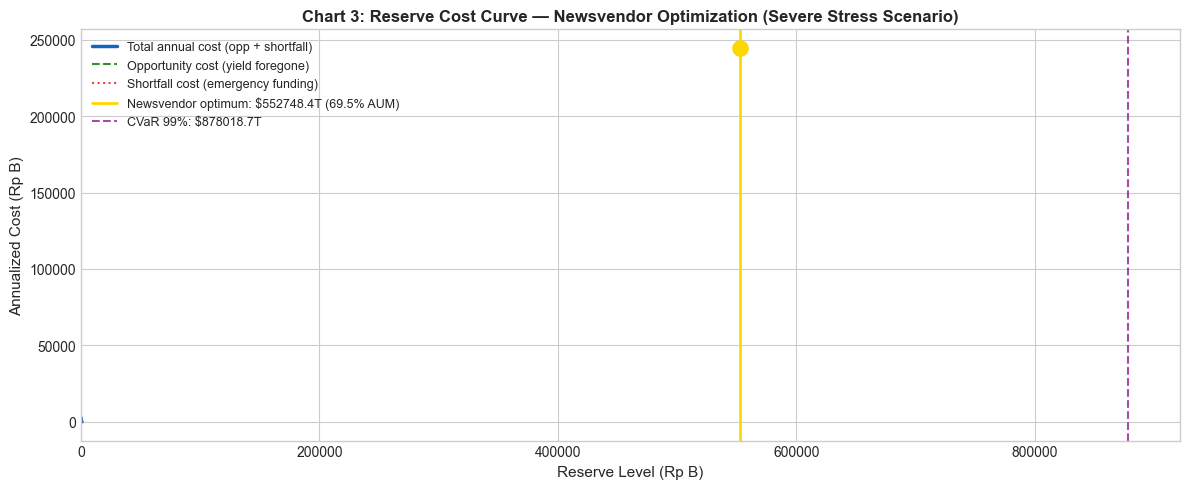

Chart 3 saved. Optimal reserve: $552748.4T (0.0% AUM)


In [6]:
# Chart 3: U-shaped cost curve (severe scenario — most instructive)
res_severe = withdrawal_results['severe']
cost_df = compute_cost_curve(res_severe['total_withdrawals'])
nv = newsvendor_optimal_reserve(res_severe['total_withdrawals'])

fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(cost_df['reserve_level']/1e9, cost_df['total_cost']/1e9,
        color='#1565C0', lw=2.5, label='Total annual cost (opp + shortfall)')
ax.plot(cost_df['reserve_level']/1e9, cost_df['opportunity_cost']/1e9,
        color='#388E3C', lw=1.5, ls='--', label='Opportunity cost (yield foregone)')
ax.plot(cost_df['reserve_level']/1e9, cost_df['shortfall_cost']/1e9,
        color=COLORS['severe'], lw=1.5, ls=':', label='Shortfall cost (emergency funding)')

# Mark newsvendor optimum
opt_r   = nv['optimal_reserve'] / 1e6
opt_idx = (cost_df['reserve_level'] - nv['optimal_reserve']).abs().idxmin()
opt_c   = cost_df.loc[opt_idx, 'total_cost'] / 1e6
ax.axvline(opt_r, color='gold', lw=2, ls='-', label=f'Newsvendor optimum: ${opt_r:.1f}T ({opt_r/AUM*1e6:.1%} AUM)')
ax.scatter([opt_r], [opt_c], s=120, color='gold', zorder=5)

# Mark CVaR level
cvar_r = nv['cvar_99_reserve'] / 1e6
ax.axvline(cvar_r, color='purple', lw=1.5, ls='--', alpha=0.7, label=f'CVaR 99%: ${cvar_r:.1f}T')

ax.set_xlabel('Reserve Level (Rp B)', fontsize=11)
ax.set_ylabel('Annualized Cost (Rp B)', fontsize=11)
ax.set_title('Chart 3: Reserve Cost Curve — Newsvendor Optimization (Severe Stress Scenario)', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.set_xlim(left=0)
plt.tight_layout()
plt.savefig('chart_03_cost_curve.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Chart 3 saved. Optimal reserve: ${opt_r:.1f}T ({opt_r/AUM*100:.1f}% AUM)")


---
## Step 4 — Stress Engine: Safety Frontier & Time-to-Insolvency

For each simulation path, we track cumulative withdrawals hour-by-hour. The first hour cumulative exceeds the reserve is the **time-to-insolvency** (TTI).

The **safety frontier** shows failure rate as a function of reserve level — the direct tradeoff curve.

In [7]:
stress_results = run_all_stress_tests(withdrawal_results, total_fiat)
stress_table   = stress_summary_table(stress_results)
print("Stress Test Results:")
display(stress_table)


Stress Test Results:


Failure Rate TTI Median (hrs) TTI Mean (hrs)
Scenario Reserve Level                                              
Normal   Newsvendor            37.1%               55             55
         Conservative           0.4%               64             63
         Industry 10Pct         0.0%                —              —
Mild     Newsvendor            37.1%               59             58
         Conservative           0.4%               63             62
         Industry 10Pct       100.0%               37             37
Severe   Newsvendor            37.1%               56             55
         Conservative           0.4%               61             61
         Industry 10Pct       100.0%                8              9

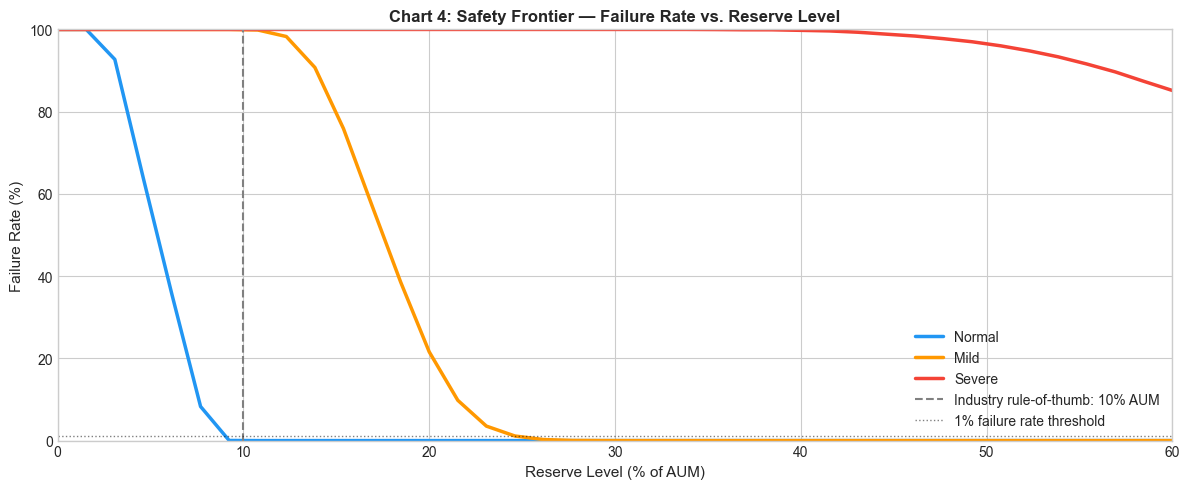

Chart 4 saved.


In [8]:
# Chart 4: Safety frontier (failure rate vs reserve level) for all scenarios
fig, ax = plt.subplots(figsize=(12, 5))

for scenario in ['normal', 'mild', 'severe']:
    frontier = compute_safety_frontier(withdrawal_results[scenario]['hourly_paths'], total_fiat, n_points=40)
    ax.plot(
        frontier['reserve_pct_aum'] * 100,
        frontier['failure_rate'] * 100,
        color=COLORS[scenario], lw=2.5, label=scenario.capitalize()
    )

ax.axvline(10, color='gray', lw=1.5, ls='--', label='Industry rule-of-thumb: 10% AUM')
ax.axhline(1,  color='black', lw=1,   ls=':', alpha=0.5, label='1% failure rate threshold')
ax.set_xlabel('Reserve Level (% of AUM)', fontsize=11)
ax.set_ylabel('Failure Rate (%)', fontsize=11)
ax.set_title('Chart 4: Safety Frontier — Failure Rate vs. Reserve Level', fontsize=12, fontweight='bold')
ax.set_xlim(0, 60)
ax.set_ylim(0, 100)
ax.legend(fontsize=10)
plt.tight_layout()
plt.savefig('chart_04_safety_frontier.png', dpi=150, bbox_inches='tight')
plt.show()
print("Chart 4 saved.")


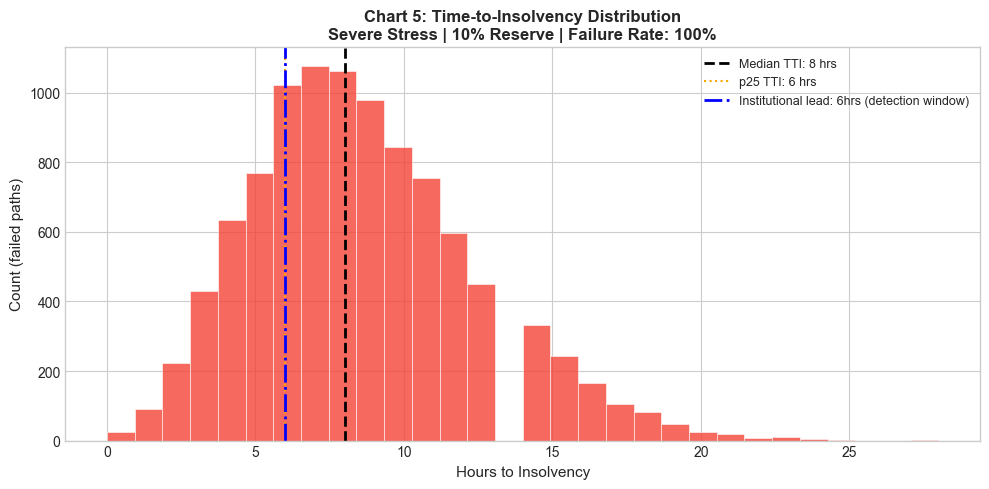

Chart 5 saved. Failure rate at 10% reserve (severe): 100%


In [9]:
# Chart 5: Time-to-Insolvency distribution (severe scenario, industry 10% reserve)
tti_data = stress_results['severe']['industry_10pct']['tti_distribution']
failure_rate = stress_results['severe']['industry_10pct']['failure_rate']

fig, ax = plt.subplots(figsize=(10, 5))

if len(tti_data) > 0:
    ax.hist(tti_data, bins=30, color=COLORS['severe'], alpha=0.8, edgecolor='white', lw=0.5)
    ax.axvline(np.median(tti_data), color='black', lw=2, ls='--', label=f'Median TTI: {np.median(tti_data):.0f} hrs')
    ax.axvline(np.percentile(tti_data, 25), color='orange', lw=1.5, ls=':', label=f'p25 TTI: {np.percentile(tti_data,25):.0f} hrs')
    # Institutional lead time annotation
    ax.axvline(cfg.INST_LEAD_TIME_HOURS['severe'], color='blue', lw=2, ls='-.',
               label=f'Institutional lead: {cfg.INST_LEAD_TIME_HOURS["severe"]}hrs (detection window)')

ax.set_xlabel('Hours to Insolvency', fontsize=11)
ax.set_ylabel('Count (failed paths)', fontsize=11)
ax.set_title(f'Chart 5: Time-to-Insolvency Distribution\nSevere Stress | 10% Reserve | Failure Rate: {failure_rate:.0%}', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
plt.tight_layout()
plt.savefig('chart_05_tti_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Chart 5 saved. Failure rate at 10% reserve (severe): {failure_rate:.0%}")


**Operational insight:** The blue line (6-hour institutional lead) is the detection window. FinOps teams that monitor institutional withdrawal velocity have ~6 hours to act before retail panic compounds the problem. Without monitoring, the window closes silently.

---
## Step 5 — Hybrid VaR Suite: Anchoring Reserve to Historical Reality

Three complementary VaR methods — not competing, but serving different purposes in a two-tier reserve structure.

**Critical observation:** VaR fails *silently* (precise number, no warning). The generative model fails *loudly* (wrong assumptions are explicit). For a risk team, a model that fails loudly is preferable.

In [10]:
market_df = pd.read_csv(cfg.MARKET_CSV_PATH)
var_result = compute_var_suite(market_df, total_fiat)
var_table  = var_comparison_table(var_result)

print("Chart 7: VaR Comparison Table — All Methods Side by Side")
display(var_table[['VaR % (99%)', 'VaR Rp B (99%)', 'Failure Mode']])

print(f"\n  EWMA Effective Sample Size : {var_result['ewma_ess_days']:.0f} days")
print(f"  Tier 1 Reserve (Instant)   : ${var_result['tier1_reserve']/1e9:.1f}M")
print(f"  Tier 2 Reserve (Liquid)    : ${var_result['tier2_reserve']/1e9:.1f}M")


Running stress tests on Rp 0.6T AUM...
Chart 7: VaR Comparison Table — All Methods Side by Side


,VaR % (99%),VaR Rp B (99%),Failure Mode
Method,,,
HS-VaR (365d),10.55%,Rp 67.1B,Blind to new regimes. Fails silently.
"FHS-VaR (EWMA λ=0.94, ESS~17d)",9.92%,Rp 63.1B,Prices current vol only. Loses memory of tail ...
Stressed VaR (worst 90-day window),11.46%,Rp 72.9B,Only as bad as worst period in data.
Parametric: MILD shock,31.10%,Rp 197.8B,Point estimate; no distribution. Forward-looki...
Parametric: SEVERE shock,58.00%,Rp 368.9B,Point estimate; no distribution. Forward-looki...
Parametric: LUNA shock,52.00%,Rp 330.7B,Point estimate; no distribution. Forward-looki...



  EWMA Effective Sample Size : 17 days
  Tier 1 Reserve (Instant)   : $67.1M
  Tier 2 Reserve (Liquid)    : $368.9M


---
## Step 6 — Insurance Fund & Liquidation Cascade

Derivatives exchanges face a hidden liability: when user margin is insufficient, the exchange absorbs the shortfall via its insurance fund. If exhausted, losses are socialized (auto-deleveraging / clawback).

**Cascade mechanism:** Liquidations amplify the initial price move → more liquidations. Simulated over 5 iteration steps.

In [11]:
print("Running insurance fund Monte Carlo (500 paths per scenario)...")
if_results = simulate_insurance_fund(total_fiat, n_simulations=500)
if_table   = insurance_fund_summary_table(if_results, total_fiat)

print(f"\nIF Initial: ${total_fiat * cfg.INSURANCE_FUND_INITIAL / 1e6:.1f}M  |  OI: ${total_fiat * cfg.OI_TO_AUM_RATIO / 1e6:.1f}T  |  Traders: {cfg.N_TRADERS:,}")
print("\nInsurance Fund Outcomes:")
display(if_table)


Running insurance fund Monte Carlo (500 paths per scenario)...



IF Initial: $3180.0M  |  OI: $954000.0T  |  Traders: 5,000

Insurance Fund Outcomes:


,IF Initial (Rp B),Mean IF Drawdown (Rp B),p99 IF Drawdown (Rp B),Exhaustion Probability,Expected Clawback (Rp B),Final Price Shock (mean)
Scenario,,,,,,
NORMAL,Rp 3.2B,Rp 0.00B,Rp 0.00B,0.0%,Rp 0.00B,0.0%
MILD,Rp 3.2B,Rp 3.18B,Rp 3.18B,100.0%,Rp 65.71B,-25.3%
SEVERE,Rp 3.2B,Rp 3.18B,Rp 3.18B,100.0%,Rp 189.30B,-50.2%
LUNA,Rp 3.2B,Rp 3.18B,Rp 3.18B,100.0%,Rp 139.30B,-40.2%


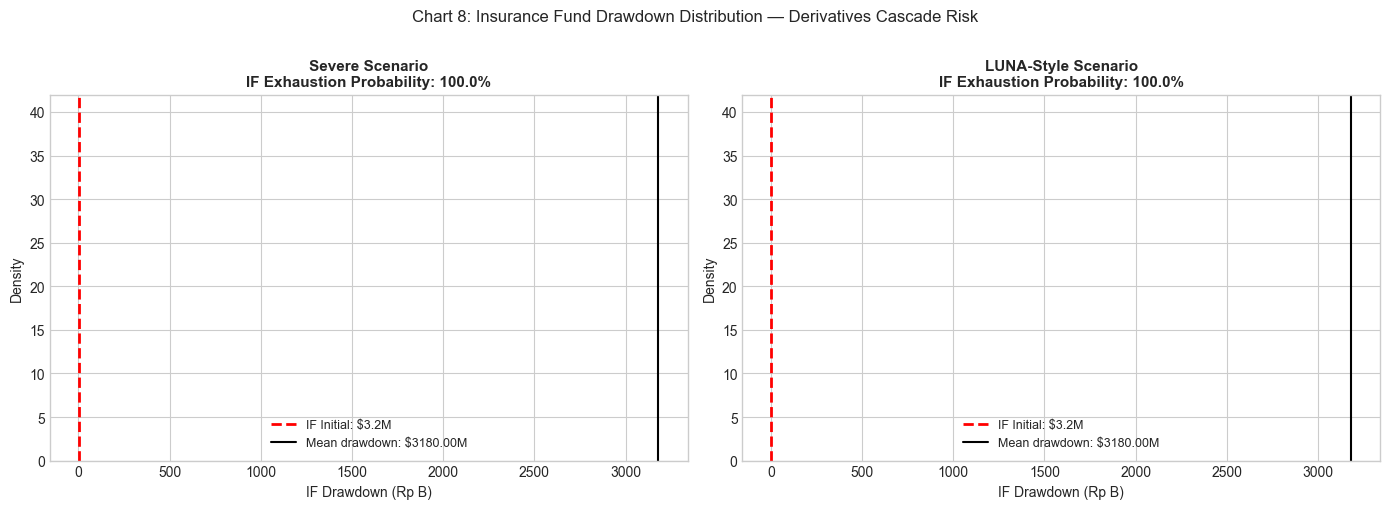

Chart 8 saved.


In [12]:
# Chart 8: IF drawdown distribution for severe + LUNA scenarios
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
if_initial = total_fiat * cfg.INSURANCE_FUND_INITIAL

for i, (sc, title_sc) in enumerate([('severe', 'Severe'), ('luna', 'LUNA-Style')]):
    ax  = axes[i]
    dd  = if_results[sc]['if_drawdown_distribution'] / 1e6
    col = COLORS['severe'] if sc == 'severe' else COLORS['luna']

    ax.hist(dd, bins=40, color=col, alpha=0.75, edgecolor='white', lw=0.3, density=True)
    ax.axvline(if_initial/1e9, color='red', lw=2, ls='--', label=f'IF Initial: ${if_initial/1e9:.1f}M')
    ax.axvline(np.mean(dd), color='black', lw=1.5, ls='-', label=f'Mean drawdown: ${np.mean(dd):.2f}M')

    exhaust_prob = if_results[sc]['exhaustion_probability']
    ax.set_title(f'{title_sc} Scenario\nIF Exhaustion Probability: {exhaust_prob:.1%}', fontsize=11, fontweight='bold')
    ax.set_xlabel('IF Drawdown (Rp B)', fontsize=10)
    ax.set_ylabel('Density', fontsize=10)
    ax.legend(fontsize=9)

plt.suptitle('Chart 8: Insurance Fund Drawdown Distribution — Derivatives Cascade Risk', fontsize=12, y=1.01)
plt.tight_layout()
plt.savefig('chart_08_insurance_fund.png', dpi=150, bbox_inches='tight')
plt.show()
print("Chart 8 saved.")


---
## Step 7 — Unified Stressed Balance Sheet

All components integrated into a single balance sheet. Three liability sources vs. three asset layers.

**This is the core output.** An exchange holding the industry rule-of-thumb (10% AUM in fiat) is demonstrated to be insolvent under severe and LUNA scenarios. This is a feature of the model, not a bug — it proves the thesis.

In [13]:
solvency_results = compute_solvency(withdrawal_results, var_result, if_results, total_fiat, fiat_reserve_pct=0.10)
solvency_table   = solvency_summary_table(solvency_results)

print("Solvency Analysis — Industry 10% Reserve Baseline:")
display(solvency_table)


Solvency Analysis — Industry 10% Reserve Baseline:


,Total Assets (Rp B),Withdrawal Demand,Deriv. Shortfall,Market Risk,Total Liabilities,Net Position (Rp B),CAR,Verdict
Scenario,,,,,,,,
NORMAL,Rp 83.5B,Rp 54.0B,Rp 0.00B,Rp 67.1B,Rp 121.1B,Rp -37.6B,0.69x,INSOLVENT ✗
MILD,Rp 83.5B,Rp 157.3B,Rp 65.71B,Rp 197.8B,Rp 420.8B,Rp -337.4B,0.20x,INSOLVENT ✗
SEVERE,Rp 83.5B,Rp 822.0B,Rp 189.30B,Rp 368.9B,Rp 1380.2B,Rp -1296.7B,0.06x,INSOLVENT ✗
LUNA,Rp 83.5B,Rp 986.4B,Rp 139.30B,Rp 330.7B,Rp 1456.4B,Rp -1372.9B,0.06x,INSOLVENT ✗


/var/folders/s1/c7bm9y8s7_59r1jmjvbtwdym0000gn/T/ipykernel_75153/1006946827.py:36: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/s1/c7bm9y8s7_59r1jmjvbtwdym0000gn/T/ipykernel_75153/1006946827.py:37: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Arial.
  plt.savefig('chart_06_balance_sheet_waterfall.png', dpi=150, bbox_inches='tight')


/Users/gilangfajar/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


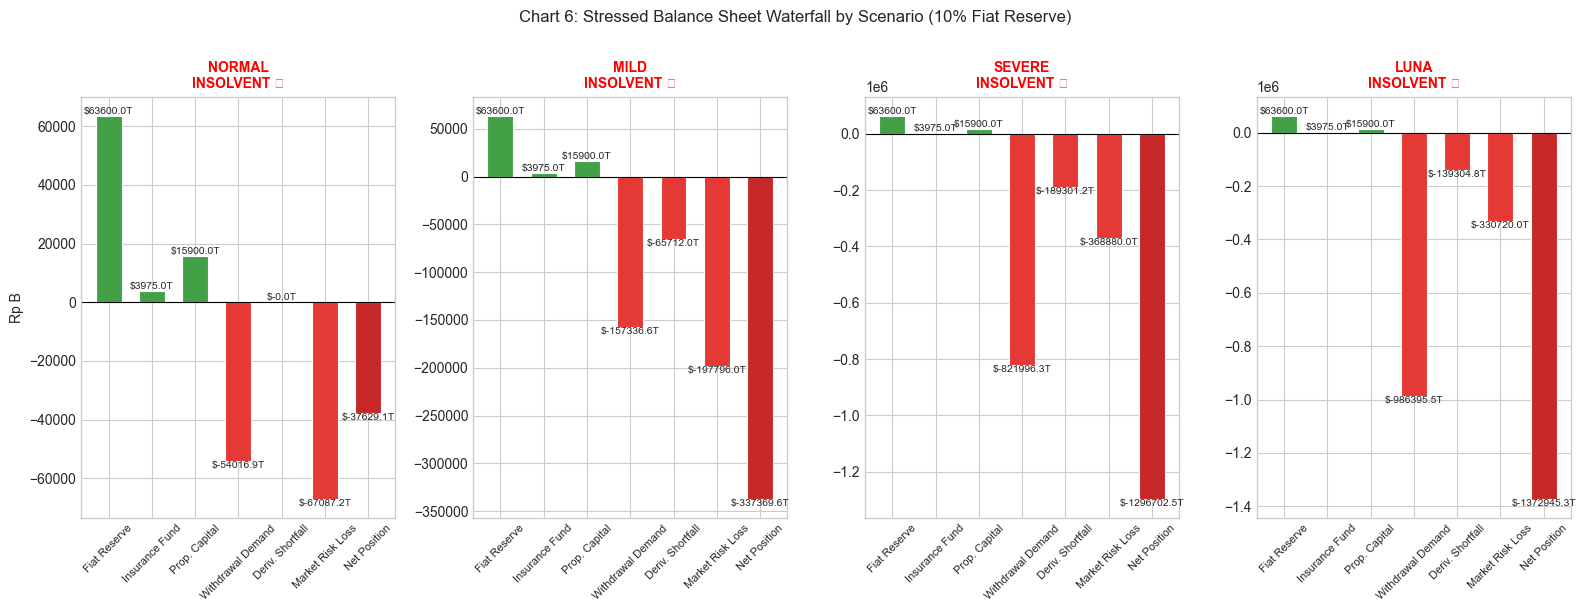

Chart 6 saved.


In [14]:
# Chart 6: Stressed Balance Sheet Waterfall
wf_data    = waterfall_data(solvency_results)
scenarios  = list(wf_data.keys())
n_sc       = len(scenarios)

fig, axes  = plt.subplots(1, n_sc, figsize=(4 * n_sc, 6), sharey=False)
if n_sc == 1: axes = [axes]

for ax, scenario in zip(axes, scenarios):
    steps     = wf_data[scenario]
    labels    = [s[0] for s in steps]
    values    = [s[1] / 1e6 for s in steps]
    types     = [s[2] for s in steps]

    bar_colors = []
    for t, v in zip(types, values):
        if t == 'asset':     bar_colors.append('#43A047')
        elif t == 'net':     bar_colors.append('#1565C0' if v >= 0 else '#C62828')
        else:                bar_colors.append('#E53935')

    bars = ax.bar(labels, values, color=bar_colors, edgecolor='white', lw=0.8, width=0.6)
    ax.axhline(0, color='black', lw=0.8)

    for bar, val in zip(bars, values):
        y_pos = bar.get_height() + 0.5 if val >= 0 else bar.get_height() - 2.5
        ax.text(bar.get_x() + bar.get_width()/2, y_pos, f'${val:.1f}T',
                ha='center', va='bottom' if val >= 0 else 'top', fontsize=7.5)

    verdict = solvency_results[scenario]['solvency_verdict']
    ax.set_title(f'{scenario.upper()}\n{verdict}', fontsize=10, fontweight='bold',
                 color='green' if '✓' in verdict else 'red')
    ax.set_ylabel('Rp B' if ax == axes[0] else '')
    ax.tick_params(axis='x', rotation=45, labelsize=8)

plt.suptitle('Chart 6: Stressed Balance Sheet Waterfall by Scenario (10% Fiat Reserve)', fontsize=12, y=1.01)
plt.tight_layout()
plt.savefig('chart_06_balance_sheet_waterfall.png', dpi=150, bbox_inches='tight')
plt.show()
print("Chart 6 saved.")


---
## Step 8 — Reserve Tiering: Composition Matters as Much as Size

Most reserve frameworks stop at "hold X%." This model derives the **composition** from the same risk framework that sized the reserve.

In [15]:
severe_if_obligation = if_results['severe']['expected_clawback']

rows = [
        {"Tier": "Layer 1 — Instant", "Instrument": "Fiat / Bank",           "Amount (Rp B)": var_result['tier1_reserve'] / 1e9, "Yield": "~0%"},
        {"Tier": "Layer 2 — Fast",    "Instrument": "Money Market / Stables", "Amount (Rp B)": (withdrawal_results['severe']['percentiles'][95] - var_result['tier1_reserve']) / 1e9, "Yield": "~6–7%"},
        {"Tier": "Layer 3 — Liquid",  "Instrument": "T-bills",                "Amount (Rp B)": (withdrawal_results['severe']['percentiles'][99] + severe_if_obligation - withdrawal_results['severe']['percentiles'][95]) / 1e9, "Yield": "~6–7%"},
    ]
print("Reserve Tier Allocation (Severe Stress):")
display(pd.DataFrame(rows).set_index("Tier"))
print(f"\n  Stablecoin caveat: USDC depegged during SVB failure (March 2023) — Layer 2 should hold stablecoins as minority, not primary instrument.")


Reserve Tier Allocation (Severe Stress):


,Instrument,Amount (Rp B),Yield
Tier,,,
Layer 1 — Instant,Fiat / Bank,67.087214,~0%
Layer 2 — Fast,Money Market / Stables,671.492189,~6–7%
Layer 3 — Liquid,T-bills,272.718082,~6–7%



  Stablecoin caveat: USDC depegged during SVB failure (March 2023) — Layer 2 should hold stablecoins as minority, not primary instrument.


---
## Board-Level Summary

**Policy recommendation output format: dollar amounts + annual cost. Not percentages.**

In [16]:
# Compute recommended reserve vs. industry baseline
nv_result_severe = newsvendor_optimal_reserve(withdrawal_results['severe']['total_withdrawals'])

print("=" * 70)
print(f"BOARD-LEVEL SUMMARY | Exchange AUM: ${AUM/1e12:.1f}T")
print("=" * 70)

print(f"\n{'SOLVENCY VERDICTS (10% fiat reserve = industry baseline)':}")
for sc, s in solvency_results.items():
    car = s['capital_adequacy_ratio']
    print(f"  {sc.upper():8s}: {s['solvency_verdict']}  |  CAR = {car:.2f}x  |  Net = ${s['net_position']/1e9:.1f}T")

print(f"\n{'RECOMMENDED RESERVE POLICY (Severe scenario, CVaR 99%)':}")
cvar99_reserve = nv_result_severe['cvar_99_reserve']
annual_hold    = nv_result_severe['annual_cost_cvar_hold']
print(f"  Required reserve                : ${cvar99_reserve/1e9:.1f}T  ({cvar99_reserve/AUM:.0%} AUM)")
print(f"  Annual opportunity cost (yield) : ${annual_hold/1e9:.1f}M/yr")
print(f"  Annual cost if unhedged (est.)  : ${nv_result_severe['annual_cost_unhedged']/1e9:.1f}M/yr")
print(f"  Net annual benefit of policy    : ${(nv_result_severe['annual_cost_unhedged'] - annual_hold)/1e9:.1f}M/yr")

print(f"\n{'TIER ALLOCATION (Severe scenario reserve)':}")
print(f"  Layer 1 — Instant (bank fiat)  : ${var_result['tier1_reserve']/1e9:.1f}M")
t2 = max(withdrawal_results['severe']['percentiles'][95] - var_result['tier1_reserve'], 0)
print(f"  Layer 2 — Fast (money market)  : ${t2/1e9:.1f}M")
t3 = max(cvar99_reserve - var_result['tier1_reserve'] - t2, 0)
print(f"  Layer 3 — Liquid (T-bills)     : ${t3/1e9:.1f}M")

print(f"\n{'MODEL LIMITATIONS (explicit)':}")
print("  [1] Institutional herding not modeled (Hawkes process — v2 enhancement)")
print("  [2] Retail panic correlation excluded — tail risk understated")
print("  [3] Single-currency USD only — EUR/GBP exchanges need separate buffers")
print("  [4] Rehypothecation excluded — off-balance-sheet leverage invisible")
print("  [5] Cross-exchange contagion not modeled")
print(f"\n{'=':=<70}")
print("See assumptions.md for full parameter documentation and calibration rationale.")


BOARD-LEVEL SUMMARY | Exchange AUM: $0.8T

SOLVENCY VERDICTS (10% fiat reserve = industry baseline)
  NORMAL  : INSOLVENT ✗  |  CAR = 0.69x  |  Net = $-37.6T
  MILD    : INSOLVENT ✗  |  CAR = 0.20x  |  Net = $-337.4T
  SEVERE  : INSOLVENT ✗  |  CAR = 0.06x  |  Net = $-1296.7T
  LUNA    : INSOLVENT ✗  |  CAR = 0.06x  |  Net = $-1372.9T

RECOMMENDED RESERVE POLICY (Severe scenario, CVaR 99%)
  Required reserve                : $878.0T  (110% AUM)
  Annual opportunity cost (yield) : $57.1M/yr
  Annual cost if unhedged (est.)  : $208.5M/yr
  Net annual benefit of policy    : $151.5M/yr

TIER ALLOCATION (Severe scenario reserve)
  Layer 1 — Instant (bank fiat)  : $67.1M
  Layer 2 — Fast (money market)  : $671.5M
  Layer 3 — Liquid (T-bills)     : $139.4M

MODEL LIMITATIONS (explicit)
  [1] Institutional herding not modeled (Hawkes process — v2 enhancement)
  [2] Retail panic correlation excluded — tail risk understated
  [3] Single-currency USD only — EUR/GBP exchanges need separate buffers

---
## Conclusions

1. **PoR is necessary but not sufficient.** It shows a snapshot of asset coverage but reveals nothing about fiat withdrawal capacity, asset quality under stress, or derivatives obligations.

2. **Institutional withdrawals dominate tail risk.** The 12x Poisson arrival rate multiplier (0.5 → 6.0/day) overwhelms retail flows in severe stress. Models focused on retail are modeling the wrong population.

3. **The industry 10% reserve rule fails under severe stress.** An exchange with 10% fiat reserves is insolvent in this model under severe withdrawal scenarios — not because of exotic assumptions, but because the math of a 64-hour bank blackout against concentrated institutional demand is unforgiving.

4. **Reserve composition matters as much as size.** Stablecoins are operationally fast but systemic risk co-moves with crypto stress (USDC depeg, SVB). Layer 2 should predominantly hold money market funds with stablecoins as a minority fast-access allocation.

5. **A model that fails loudly is preferable.** VaR gives a precise number with no warning that it's wrong. The Gamma/Poisson generative model makes assumptions explicit and debatable. For a FinOps team, the ability to challenge assumptions is more valuable than false precision.

---
*Model v1 | See `assumptions.md` for full parameter documentation | v2: Hawkes process, multi-currency, ETH-ALT correlation refinement*